In [1]:
import os

import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("dark_background")

In [2]:
# read in trade OD matrix

root_dir = ".."
od_dir = os.path.join(root_dir, "results/input/trade_matrix")
od = pd.read_parquet(os.path.join(od_dir, "trade_nodes_total.parquet"))

In [3]:
# country boundaries for diagnostic plotting

countries = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))

In [4]:
country_volume_total = od.loc[:, ["partner_GID_0", "volume_tons"]].groupby("partner_GID_0").sum()
country_volume_total.index.name = "GID_0"

<Axes: >

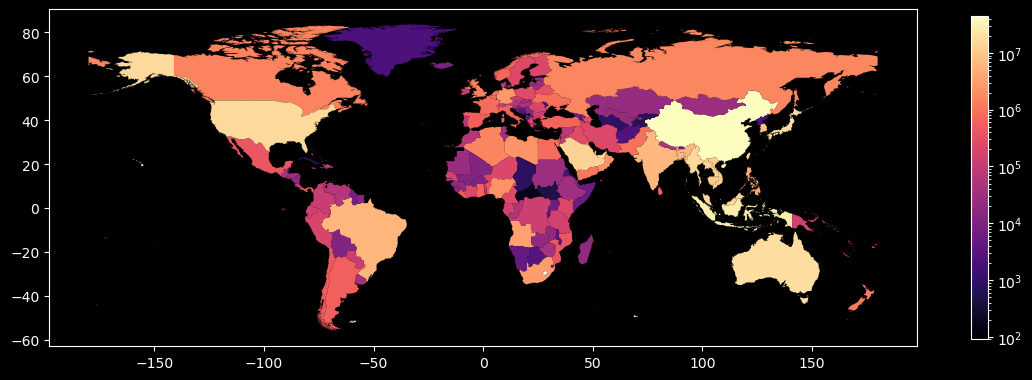

In [5]:
f, ax = plt.subplots(figsize=(14, 7))
to_plot = countries.set_index("GID_0").join(country_volume_total)
cmap = plt.get_cmap("magma")
cmap.set_under("white")
to_plot.plot(
    "volume_tons",
    ax=ax,
    cmap=cmap,
    legend=True,
    norm=matplotlib.colors.LogNorm(
        vmin=to_plot.volume_tons.max(),
        vmax=1E2
    ),
    legend_kwds={
        "shrink": 0.6
    },
)

Text(0.5, 0, 'Trade volume [t / a]')

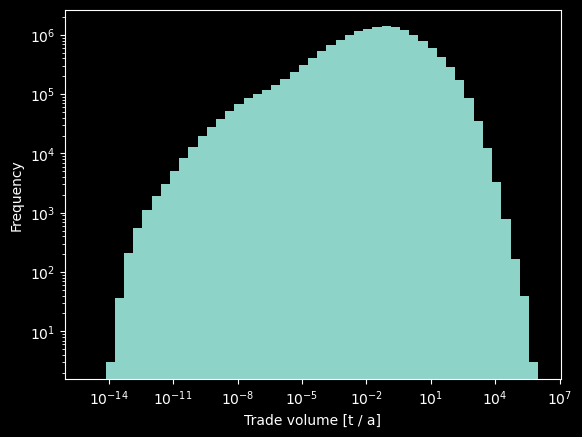

In [6]:
f, ax = plt.subplots()
ax.hist(od.volume_tons.values, bins=np.logspace(-15, 6, 50))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel("Trade volume [t / a]")

Text(0.5, 0, 'Trade value [k$ / a]')

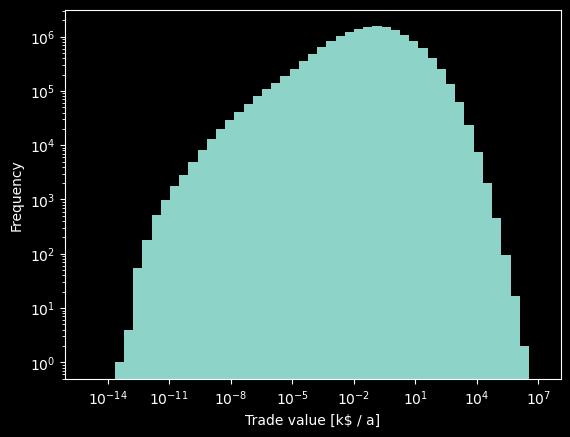

In [7]:
f, ax = plt.subplots()
ax.hist(od.value_kusd.values, bins=np.logspace(-15, 7, 50))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel("Trade value [k$ / a]")

In [8]:
# original OD has ~21M pairs
# let's drop any pair with a volume of less than x tons
threshold_t = 5
to_plot = od
to_plot = to_plot[to_plot.volume_tons > threshold_t]
print(f"Removing pairs with volume <{threshold_t} tons\n")
print("\tTotal before\tTotal after\tChange")
print(
    f"Volume\t{od.volume_tons.sum():1.2E}"
    f"\t{to_plot.volume_tons.sum():1.2E}"
    f"\t{100 * (to_plot.volume_tons.sum() - od.volume_tons.sum()) / to_plot.volume_tons.sum():1.2f}%"
)
print(
    f"Value\t{od.value_kusd.sum():1.2E}"
    f"\t{to_plot.value_kusd.sum():1.2E}"
    f"\t{100 * (to_plot.value_kusd.sum() - od.value_kusd.sum()) / to_plot.value_kusd.sum():1.2f}%"
)
print(f"\n{len(od)=}")
print(f"{len(to_plot)=}")

Removing pairs with volume <5 tons

	Total before	Total after	Change
Volume	3.33E+08	3.28E+08	-1.50%
Value	5.96E+08	5.82E+08	-2.45%

len(od)=21431475
len(to_plot)=1900266


In [9]:
to_plot

,id,THA_GID_1,partner_GID_0,value_kusd,volume_tons,GID_1
231,thailand-latest_14_1060,THA.10_1,ARE,5.958418,8.921528,THA.10_1
237,thailand-latest_14_1060,THA.10_1,AUS,10.831574,15.529106,THA.10_1
255,thailand-latest_14_1060,THA.10_1,BRA,8.044474,14.040133,THA.10_1
265,thailand-latest_14_1060,THA.10_1,CHN,85.528901,55.493995,THA.10_1
318,thailand-latest_14_1060,THA.10_1,IDN,9.702360,15.393054,THA.10_1
...,...,...,...,...,...,...
21430557,thailand-latest_43_125,THA.9_1,TWN,279.253313,112.164923,THA.9_1
21430560,thailand-latest_43_125,THA.9_1,UKR,40.033643,173.468912,THA.9_1
21430562,thailand-latest_43_125,THA.9_1,USA,746.706741,696.701952,THA.9_1
21430567,thailand-latest_43_125,THA.9_1,VNM,281.980553,180.195683,THA.9_1


In [10]:
to_plot.loc[:, ["partner_GID_0", "volume_tons"]] \
    .groupby("partner_GID_0").sum() \
    .sort_values("volume_tons", ascending=False).iloc[:15]

,volume_tons
partner_GID_0,
CHN,4.474680e+07
IDN,2.750208e+07
ARE,1.905759e+07
AUS,1.798173e+07
JPN,1.762128e+07
USA,1.666831e+07
MYS,1.563507e+07
TWN,1.475055e+07
MMR,1.457195e+07


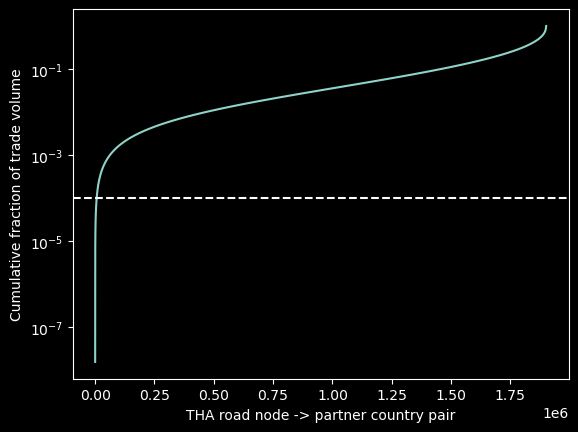

In [11]:
f, ax = plt.subplots()
ax.step(range(len(to_plot)), np.cumsum(to_plot.volume_tons.sort_values()) / np.sum(to_plot.volume_tons))
ax.set_ylabel("Cumulative fraction of trade volume")
ax.set_xlabel("THA road node -> partner country pair")
ax.axhline(1E-4, ls='--')
ax.set_yscale("log")

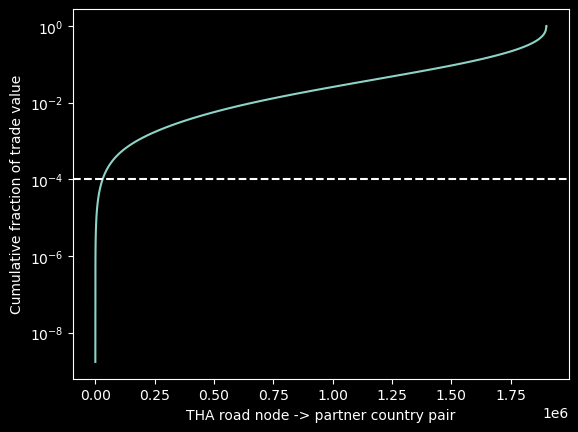

In [12]:
f, ax = plt.subplots()
ax.step(range(len(to_plot)), np.cumsum(to_plot.value_kusd.sort_values()) / np.sum(to_plot.value_kusd))
ax.set_ylabel("Cumulative fraction of trade value")
ax.set_xlabel("THA road node -> partner country pair")
ax.axhline(1E-4, ls='--')
ax.set_yscale("log")